In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Data loading

In [2]:
dfA = pd.read_csv('test_results/A_rated_rag_results.csv')
dfB = pd.read_csv('test_results/B_rated_rag_results.csv')
dfC = pd.read_csv('test_results/C_rated_rag_results.csv')

In [3]:
df_combined = pd.concat([dfA, dfB, dfC], axis=0, ignore_index=True)

df_combined.head()

,rag_system,embedding_model,query,retrieved_titles,golden_route,precision,recall,num_retrieved_from_golden,locations,response,...,count_relevant,count_good,checker_response,checker_time,checker_total_tokens,checker_prompt_tokens,query_enhancer_time,enhancer_response,enhancer_total_tokens,enhancer_prompt_tokens
0,RAGSystemA,sentence-transformers/all-MiniLM-L6-v2,skyscrapers in the Hague,"['B-PROUD', 'Witte Anna', ""Rijksbeschermd gezi...","['Hoftoren', 'Het Strijkijzer', 'De Kroon (woo...",0.000,0.0,0,"[{'title': 'B-PROUD', 'main_category': 'skyscr...",NaN,...,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RAGSystemA,sentence-transformers/all-MiniLM-L6-v2,What should a museum nerd see in Haarlem,"['Archeologisch Museum Haarlem', 'Verwey Museu...","['Frans Hals Museum', 'Verwey Museum Haarlem',...",0.375,0.6,3,"[{'title': 'Archeologisch Museum Haarlem', 'ma...",NaN,...,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RAGSystemA,sentence-transformers/all-MiniLM-L6-v2,I like metro systems. Which stations are inter...,"['Station Amsterdam Sloterdijk', 'Station Amst...","['Nieuwmarkt (metrostation)', 'Rokin (metrosta...",0.000,0.0,0,"[{'title': 'Station Amsterdam Sloterdijk', 'ma...",NaN,...,6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RAGSystemA,sentence-transformers/all-MiniLM-L6-v2,brutalist architecture Amsterdam,"['Hoofdgebouw Vrije Universiteit', 'Opengewerk...","['Hoofdgebouw Vrije Universiteit', 'Leeuwenbur...",0.125,0.2,1,"[{'title': 'Hoofdgebouw Vrije Universiteit', '...",NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RAGSystemA,sentence-transformers/all-MiniLM-L6-v2,I want to see the most famous bridges of Amste...,"['Brug 53', 'Kolksluis (Amsterdam)', 'Brug 831...","['Oudekerksbrug', 'Blauwbrug', 'Aluminiumbrug'...",0.000,0.0,0,"[{'title': 'Brug 53', 'main_category': 'bridge...",NaN,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_combined.columns

Index(['rag_system', 'embedding_model', 'query', 'retrieved_titles',
       'golden_route', 'precision', 'recall', 'num_retrieved_from_golden',
       'locations', 'response', 'query_embedding_time', 'retrieval_time',
       'summary_generation_time', 'summary_total_tokens',
       'summary_prompt_tokens', 'irrelevant_wrong_area', 'relevant_wrong_area',
       'irrelevant', 'relevant', 'good', 'count_irrelevant_wrong_area',
       'count_relevant_wrong_area', 'count_irrelevant', 'count_relevant',
       'count_good', 'checker_response', 'checker_time',
       'checker_total_tokens', 'checker_prompt_tokens', 'query_enhancer_time',
       'enhancer_response', 'enhancer_total_tokens', 'enhancer_prompt_tokens'],
      dtype='object')

In [5]:
# Identify columns related to time and tokens
time_token_columns = [col for col in df_combined.columns if 'time' in col.lower() or 'token' in col.lower()]

# Fill NaN values in these columns with 0
df_combined[time_token_columns] = df_combined[time_token_columns].fillna(0)

df_combined["rag_system"] = df_combined["rag_system"].replace({
    "RAGSystemB": "RAGSystemB (checker)",
    "RAGSystemC": "RAGSystemC (enhancer)"
})

# Graph making

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Response time

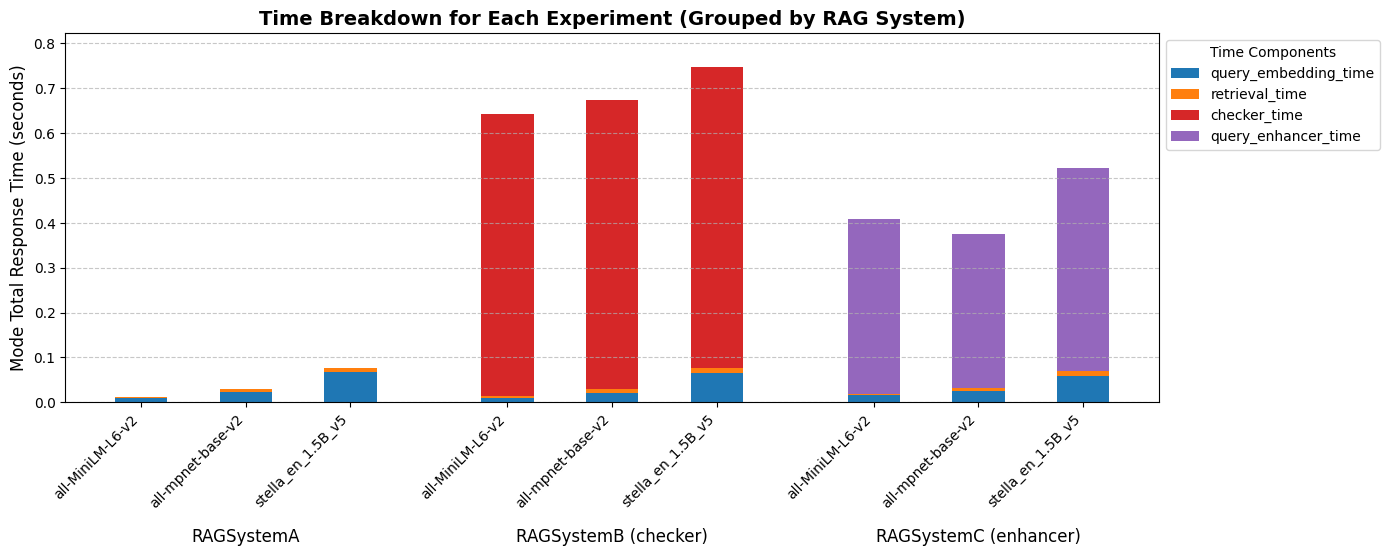

In [7]:

# Define a consistent color palette for the time components
colors = {
    'query_embedding_time': '#1f77b4',
    'retrieval_time': '#ff7f0e',
    #'summary_generation_time': '#2ca02c',
    'checker_time': '#d62728',
    'query_enhancer_time': '#9467bd'
}

# Shorten embedding model names
df_combined["short_embedding_model"] = df_combined["embedding_model"].apply(lambda x: x.split("/")[-1])

# Create a unique identifier for experiments grouped by RAG system
df_combined["experiment"] = df_combined["rag_system"] + " | " + df_combined["short_embedding_model"]

# Define the time-related columns
time_columns = list(colors.keys())

# Aggregate by RAG system and short embedding model using mode
def mode_agg(x):
    return x.mode()[0] if not x.mode().empty else np.nan

df_grouped = df_combined.groupby(["rag_system", "short_embedding_model"])[time_columns].agg(mode_agg)

# Prepare data for plotting
rag_systems = df_grouped.index.get_level_values(0).unique()
x_ticks = []
x_positions = []

fig, ax = plt.subplots(figsize=(14, 6))

# Initialize bar positions
x_base = 0
width = 0.5  

# Plot stacked bars for each rag_system
for rag_system in rag_systems:
    df_subset = df_grouped.loc[rag_system]
    x = np.arange(len(df_subset)) + x_base
    bottom = np.zeros(len(df_subset))
    for time_type in time_columns:
        ax.bar(x, df_subset[time_type], width=width, label=time_type if rag_system == rag_systems[0] else "",
               bottom=bottom, color=colors[time_type])
        bottom += df_subset[time_type].values
    
    # Add labels for rag_system grouping
    mid_x = x.mean()
    ax.text(mid_x, -0.30, rag_system, ha='center', va='center', fontsize=12, transform=ax.transData)

    # Update x_ticks and x_positions
    x_ticks.extend(df_subset.index)
    x_positions.extend(x)
    x_base += len(df_subset) + 0.5  # Add more space between rag_system groups

# Adjust y-axis height
y_max = df_grouped[time_columns].sum(axis=1).max()
ax.set_ylim(0, y_max * 1.1)

# Formatting
plt.title("Time Breakdown for Each Experiment (Grouped by RAG System)", fontsize=14, fontweight='bold')
plt.ylabel("Mode Total Response Time (seconds)", fontsize=12)
plt.xticks(x_positions, x_ticks, rotation=45, ha='right', fontsize=10)
plt.legend(title="Time Components", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


## Token use

In [55]:
token_columns = [
    'summary_total_tokens', 'summary_prompt_tokens', 
    'checker_total_tokens', 'checker_prompt_tokens', 
    'enhancer_total_tokens', 'enhancer_prompt_tokens'
]

# Aggregate by rag_system and embedding model
df_combined["short_embedding_model"] = df_combined["embedding_model"].apply(lambda x: x.split("/")[-1])
df_combined["experiment"] = df_combined["rag_system"] + " | " + df_combined["short_embedding_model"]

# Sum tokens for each experiment
df_combined["mean_total_tokens"] = df_combined[token_columns].sum(axis=1)

# Group by experiment and calculate mean total tokens
df_token_mean = df_combined.groupby("rag_system")["mean_total_tokens"].mean().round().reset_index()
df_token_mean


,rag_system,mean_total_tokens
0,RAGSystemA,0.0
1,RAGSystemB (checker),1764.0
2,RAGSystemC (enhancer),208.0


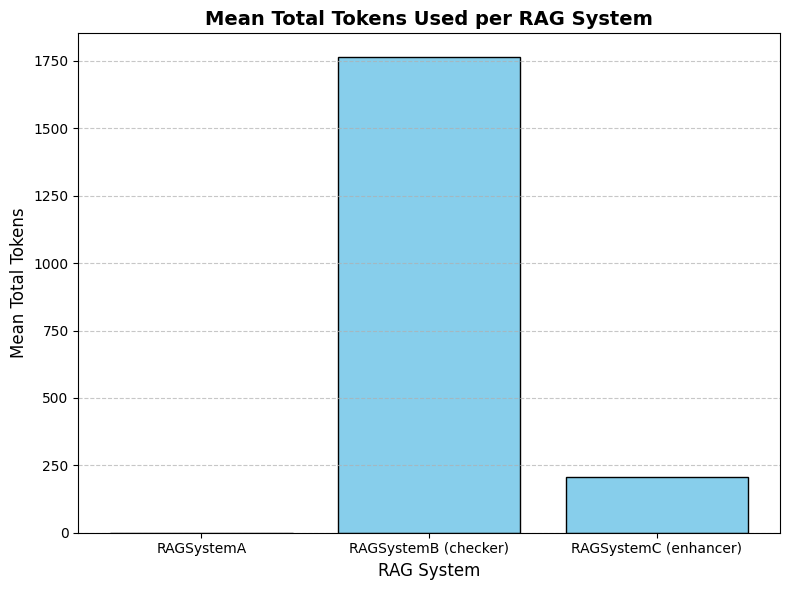

In [9]:
# Group by RAG system and calculate mean total tokens
df_token_mean = df_combined.groupby("rag_system")["total_tokens"].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(df_token_mean["rag_system"], df_token_mean["total_tokens"], color="skyblue", edgecolor="black")

# Add labels and title
plt.title("Mean Total Tokens Used per RAG System", fontsize=14, fontweight="bold")
plt.xlabel("RAG System", fontsize=12)
plt.ylabel("Mean Total Tokens", fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


## Hits

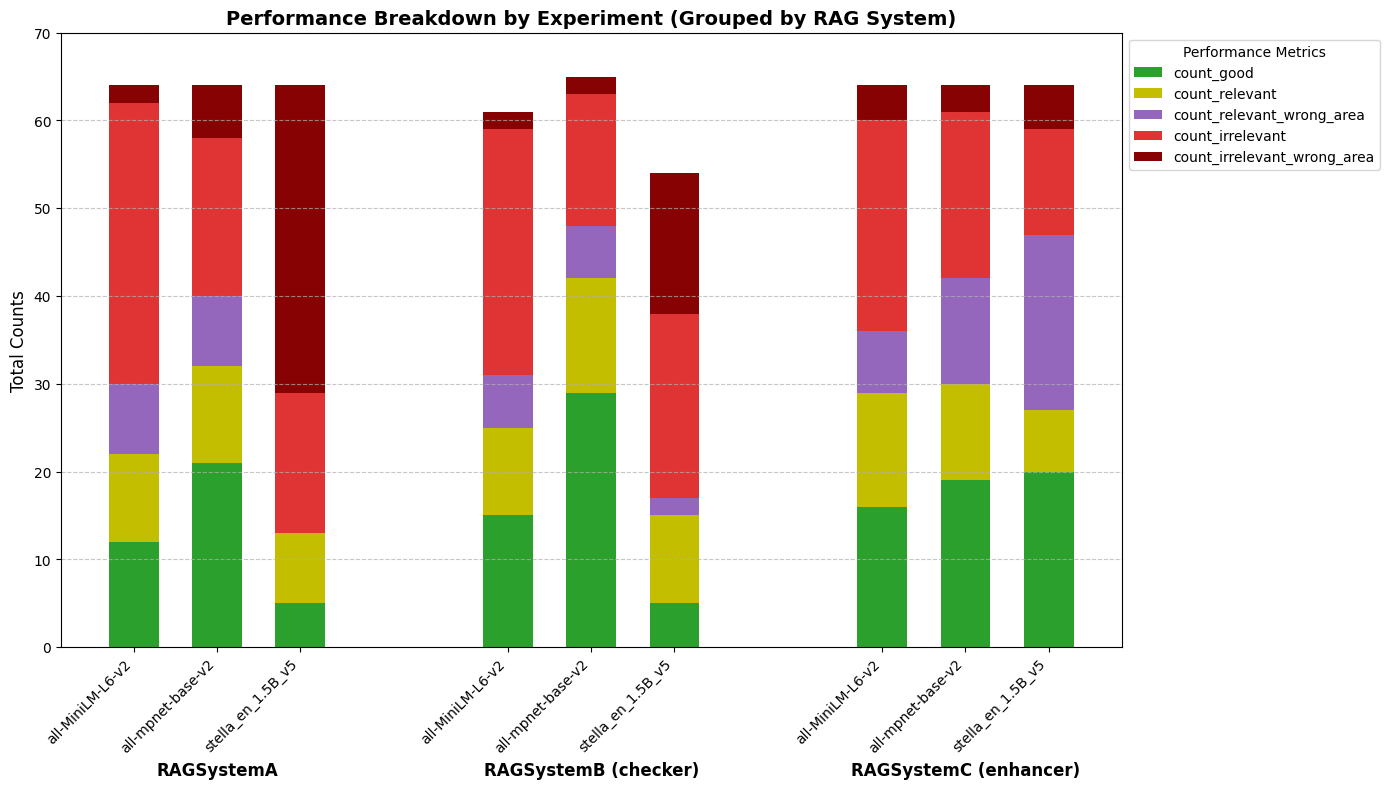

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define the correct columns for counts
count_columns = [
    'count_good',
    'count_relevant',
    'count_relevant_wrong_area',
    'count_irrelevant',
    'count_irrelevant_wrong_area'
]

# Define colors for the count components
count_colors = {
    'count_good': '#2ca02c',  
    'count_relevant': '#c4be00',  
    'count_relevant_wrong_area': '#9467bd', 
    'count_irrelevant': '#e03434',  
    'count_irrelevant_wrong_area': '#870303'  
}

# Ensure count columns are numeric
df_combined[count_columns] = df_combined[count_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Aggregate by RAG system and embedding model using total counts
df_grouped_counts = df_combined.groupby(["rag_system", "short_embedding_model"])[count_columns].sum()

# Prepare data for plotting
rag_systems = df_grouped_counts.index.get_level_values(0).unique()
x_ticks = []
x_positions = []

fig, ax = plt.subplots(figsize=(14, 8))

# Initialize bar positions
x_base = 0
width = 0.6  # Bar width

# Plot stacked bars for each rag_system
for rag_system in rag_systems:
    df_subset = df_grouped_counts.loc[rag_system]
    x = np.arange(len(df_subset)) + x_base
    bottom = np.zeros(len(df_subset), dtype=float)
    for count_type in count_columns:
        ax.bar(x, df_subset[count_type], width=width, label=count_type if rag_system == rag_systems[0] else "",
               bottom=bottom, color=count_colors[count_type])
        bottom += df_subset[count_type].values  # Update bottom for stacking
    
    # Add labels for rag_system grouping
    mid_x = x.mean()
    ax.text(mid_x, -14, rag_system, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transData)

    # Update x_ticks and x_positions
    x_ticks.extend(df_subset.index)
    x_positions.extend(x)
    x_base += len(df_subset) + 1.5  # Add more space between rag_system groups

# Adjust y-axis height
#y_max = df_grouped_counts[count_columns].sum(axis=1).max()
ax.set_ylim(0, 70)

# Formatting
plt.title("Performance Breakdown by Experiment (Grouped by RAG System)", fontsize=14, fontweight='bold')
plt.ylabel("Total Counts", fontsize=12)
plt.xticks(x_positions, x_ticks, rotation=45, ha='right', fontsize=10)
plt.legend(title="Performance Metrics", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


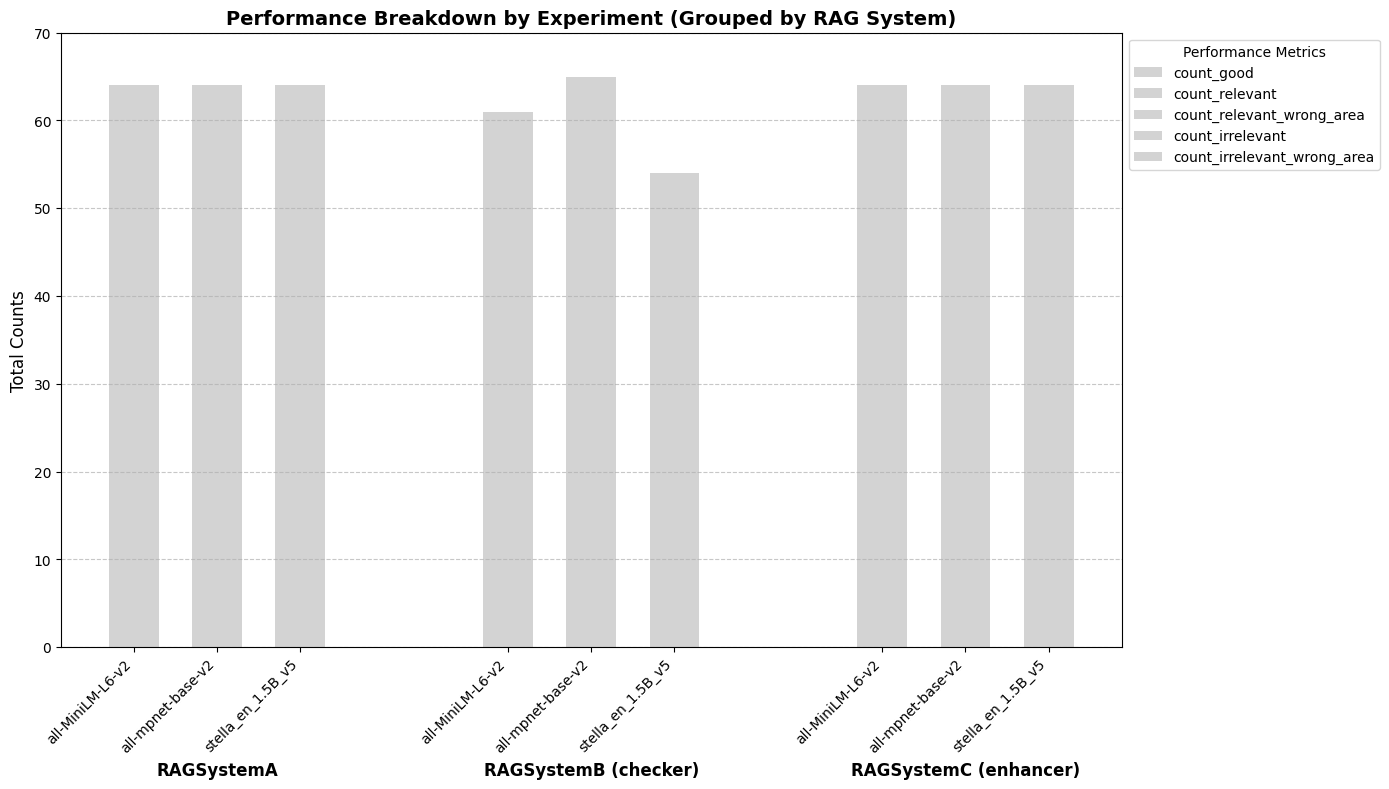

In [11]:
# Define the correct columns for counts
count_columns = [
    'count_good',
    'count_relevant',
    'count_relevant_wrong_area',
    'count_irrelevant',
    'count_irrelevant_wrong_area'
]

# Define colors for the count components
count_colors = {
    'count_good': '#d3d3d3',  
    'count_relevant': '#d3d3d3',  
    'count_relevant_wrong_area': '#d3d3d3', 
    'count_irrelevant': '#d3d3d3',  
    'count_irrelevant_wrong_area': '#d3d3d3'  
}

# Ensure count columns are numeric
df_combined[count_columns] = df_combined[count_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Aggregate by RAG system and embedding model using total counts
df_grouped_counts = df_combined.groupby(["rag_system", "short_embedding_model"])[count_columns].sum()

# Prepare data for plotting
rag_systems = df_grouped_counts.index.get_level_values(0).unique()
x_ticks = []
x_positions = []

fig, ax = plt.subplots(figsize=(14, 8))

# Initialize bar positions
x_base = 0
width = 0.6  # Bar width

# Plot stacked bars for each rag_system
for rag_system in rag_systems:
    df_subset = df_grouped_counts.loc[rag_system]
    x = np.arange(len(df_subset)) + x_base
    bottom = np.zeros(len(df_subset), dtype=float)
    for count_type in count_columns:
        ax.bar(x, df_subset[count_type], width=width, label=count_type if rag_system == rag_systems[0] else "",
               bottom=bottom, color=count_colors[count_type])
        bottom += df_subset[count_type].values  # Update bottom for stacking
    
    # Add labels for rag_system grouping
    mid_x = x.mean()
    ax.text(mid_x, -14, rag_system, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transData)

    # Update x_ticks and x_positions
    x_ticks.extend(df_subset.index)
    x_positions.extend(x)
    x_base += len(df_subset) + 1.5  # Add more space between rag_system groups

# Adjust y-axis height
#y_max = df_grouped_counts[count_columns].sum(axis=1).max()
ax.set_ylim(0, 70)

# Formatting
plt.title("Performance Breakdown by Experiment (Grouped by RAG System)", fontsize=14, fontweight='bold')
plt.ylabel("Total Counts", fontsize=12)
plt.xticks(x_positions, x_ticks, rotation=45, ha='right', fontsize=10)
plt.legend(title="Performance Metrics", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


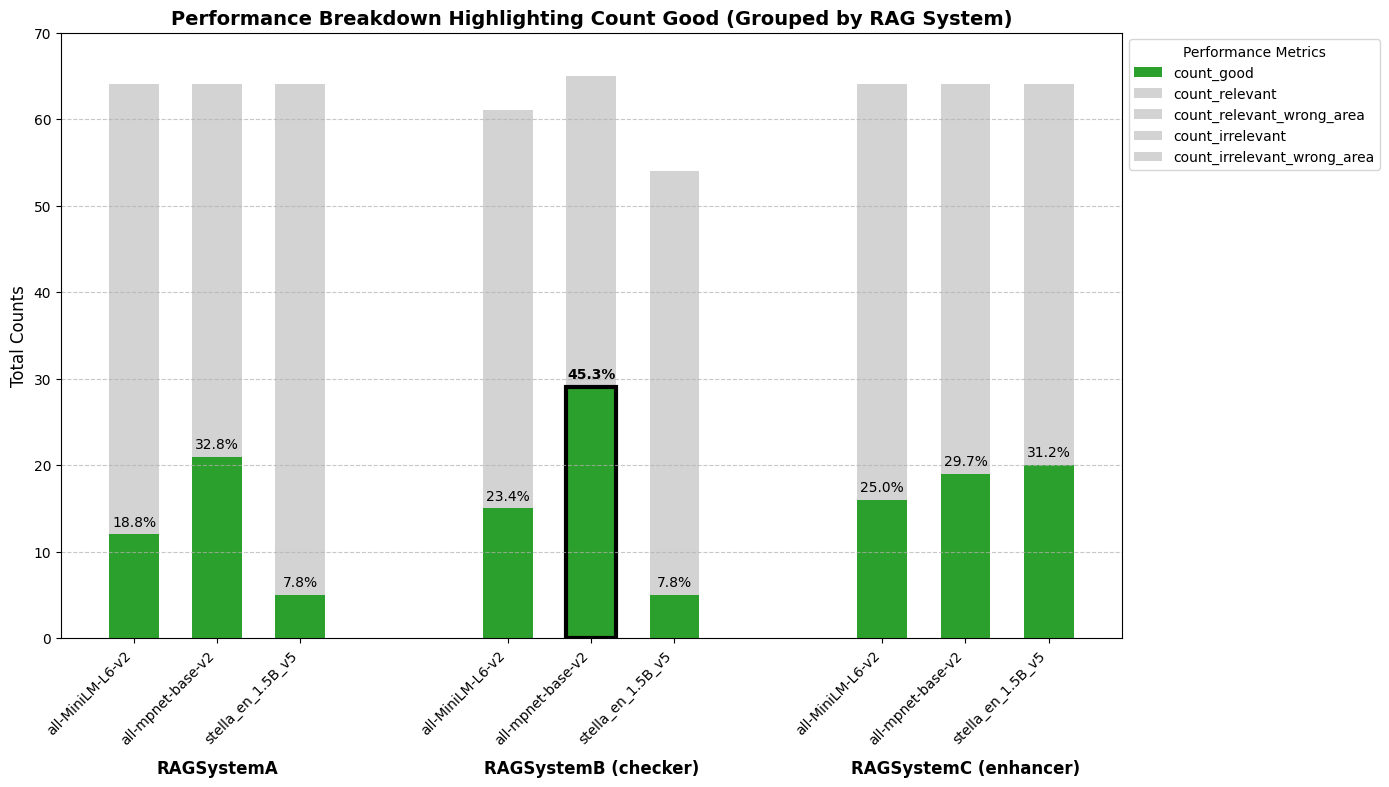

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define updated colors: gray for all except count_good
highlight_colors = {
    'count_good': '#2ca02c',  # Green for good
    'count_relevant': '#d3d3d3',  # Gray for relevant
    'count_irrelevant': '#d3d3d3',  # Gray for irrelevant
    'count_relevant_wrong_area': '#d3d3d3',  # Gray for relevant but wrong area
    'count_irrelevant_wrong_area': '#d3d3d3'  # Gray for irrelevant and wrong area
}

# Prepare data for plotting
rag_systems = df_grouped_counts.index.get_level_values(0).unique()
x_ticks = []
x_positions = []

fig, ax = plt.subplots(figsize=(14, 8))

# Initialize bar positions
x_base = 0
width = 0.6  # Bar width

# Calculate percentages for count_good
df_grouped_counts['percent_good'] = (df_grouped_counts['count_good'] / 64) * 100

# Identify the experiment with the highest percentage
max_percent_idx = df_grouped_counts['percent_good'].idxmax()
max_percent_value = df_grouped_counts['percent_good'].max()

# Plot stacked bars for each rag_system
for rag_system in rag_systems:
    df_subset = df_grouped_counts.loc[rag_system]
    x = np.arange(len(df_subset)) + x_base
    bottom = np.zeros(len(df_subset), dtype=float)
    for count_type in count_columns:
        color = highlight_colors[count_type]  # Use gray for all except count_good
        bars = ax.bar(x, df_subset[count_type], width=width, label=count_type if rag_system == rag_systems[0] else "",
                      bottom=bottom, color=color)
        if count_type == 'count_good':
            # Add percentage labels on top of the count_good bars
            for i, bar in enumerate(bars):
                percent = df_subset['percent_good'].iloc[i]
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bottom[i] + 1, 
                        f"{percent:.1f}%", ha='center', fontsize=10, fontweight='bold' if percent == max_percent_value else 'normal')
        bottom += df_subset[count_type].values  # Update bottom for stacking

    # Add labels for rag_system grouping
    mid_x = x.mean()
    ax.text(mid_x, -15, rag_system, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transData)

    # Update x_ticks and x_positions
    x_ticks.extend(df_subset.index)
    x_positions.extend(x)
    x_base += len(df_subset) + 1.5  # Add more space between rag_system groups

# Highlight the highest percentage bar
x_highlight = x_positions[list(df_grouped_counts.index).index(max_percent_idx)]
ax.bar(x_highlight, df_grouped_counts.loc[max_percent_idx, 'count_good'], width=width, edgecolor='black', linewidth=3, facecolor=highlight_colors['count_good'])

# Adjust y-axis height
#y_max = df_grouped_counts[count_columns].sum(axis=1).max()
ax.set_ylim(0, 70)

# Formatting
plt.title("Performance Breakdown Highlighting Count Good (Grouped by RAG System)", fontsize=14, fontweight='bold')
plt.ylabel("Total Counts", fontsize=12)
plt.xticks(x_positions, x_ticks, rotation=45, ha='right', fontsize=10)
plt.legend(title="Performance Metrics", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


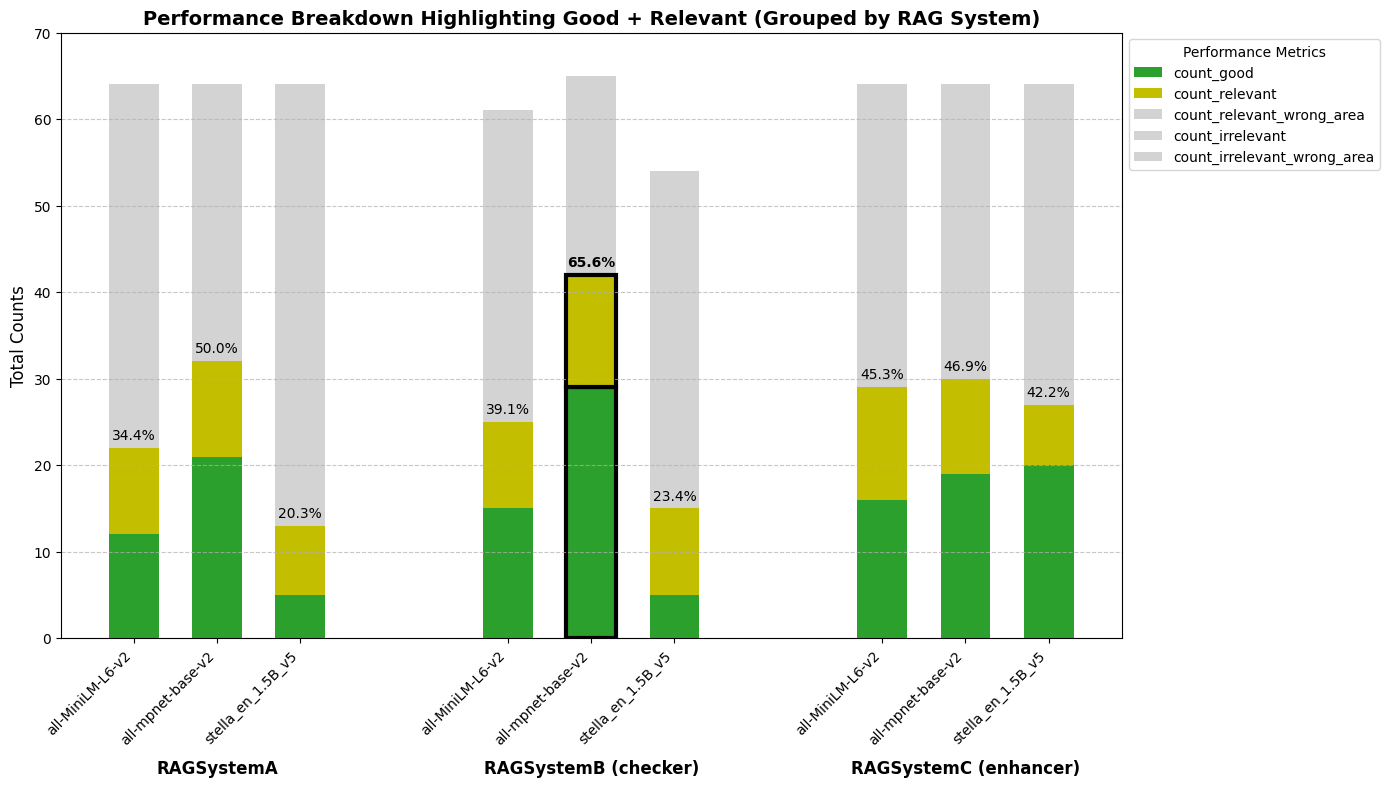

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define updated colors: un-gray "count_relevant"
highlight_colors = {
    'count_good': '#2ca02c',  # Green for good
    'count_relevant': '#c4be00',  
    'count_irrelevant': '#d3d3d3',  # Gray for irrelevant
    'count_relevant_wrong_area': '#d3d3d3',  # Gray for relevant but wrong area
    'count_irrelevant_wrong_area': '#d3d3d3'  # Gray for irrelevant and wrong area
}

# Prepare data for plotting
rag_systems = df_grouped_counts.index.get_level_values(0).unique()
x_ticks = []
x_positions = []

fig, ax = plt.subplots(figsize=(14, 8))

# Initialize bar positions
x_base = 0
width = 0.6  # Bar width

# Calculate combined percentages for count_good + count_relevant
df_grouped_counts['percent_combined'] = ((df_grouped_counts['count_good'] + df_grouped_counts['count_relevant']) / 64) * 100

# Identify the experiment with the highest combined percentage
max_percent_idx = df_grouped_counts['percent_combined'].idxmax()
max_percent_value = df_grouped_counts['percent_combined'].max()

# Plot stacked bars for each rag_system
for rag_system in rag_systems:
    df_subset = df_grouped_counts.loc[rag_system]
    x = np.arange(len(df_subset)) + x_base
    bottom = np.zeros(len(df_subset), dtype=float)
    for count_type in count_columns:
        color = highlight_colors[count_type]  # Apply updated colors
        bars = ax.bar(x, df_subset[count_type], width=width, label=count_type if rag_system == rag_systems[0] else "",
                      bottom=bottom, color=color)
        # Only add percentages for count_good + count_relevant
        if count_type == 'count_relevant':
            for i, bar in enumerate(bars):
                combined_height = bottom[i] + df_subset[count_type].iloc[i]
                percent = df_subset['percent_combined'].iloc[i]
                ax.text(bar.get_x() + bar.get_width() / 2, combined_height + 1, 
                        f"{percent:.1f}%", ha='center', fontsize=10, fontweight='bold' if percent == max_percent_value else 'normal')
        bottom += df_subset[count_type].values  # Update bottom for stacking

    # Add labels for rag_system grouping
    mid_x = x.mean()
    ax.text(mid_x, -15, rag_system, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transData)

    # Update x_ticks and x_positions
    x_ticks.extend(df_subset.index)
    x_positions.extend(x)
    x_base += len(df_subset) + 1.5  # Add more space between rag_system groups

# Highlight the highest combined percentage bar (split into stacks)
highlight_values = df_grouped_counts.loc[max_percent_idx, ['count_good', 'count_relevant']]
highlight_bottom = 0
for i, (metric, value) in enumerate(highlight_values.items()):
    ax.bar(x_highlight, value, width=width, color=highlight_colors[metric],
           edgecolor='black', linewidth=3, bottom=highlight_bottom)
    highlight_bottom += value

# Adjust y-axis height
ax.set_ylim(0, 70)

# Formatting
plt.title("Performance Breakdown Highlighting Good + Relevant (Grouped by RAG System)", fontsize=14, fontweight='bold')
plt.ylabel("Total Counts", fontsize=12)
plt.xticks(x_positions, x_ticks, rotation=45, ha='right', fontsize=10)
plt.legend(title="Performance Metrics", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


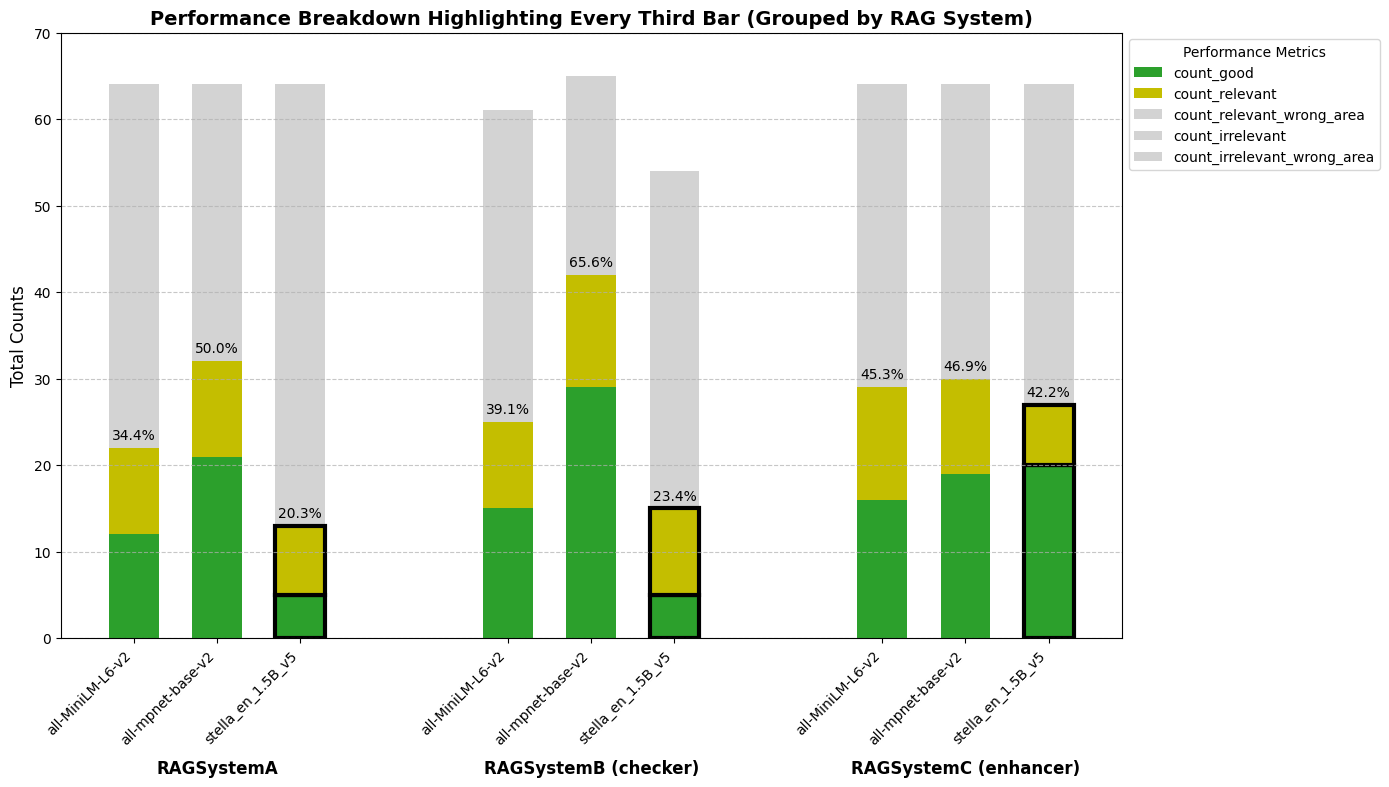

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define updated colors: un-gray "count_relevant"
highlight_colors = {
    'count_good': '#2ca02c',  # Green for good
    'count_relevant': '#c4be00',  # Yellow for relevant
    'count_irrelevant': '#d3d3d3',  # Gray for irrelevant
    'count_relevant_wrong_area': '#d3d3d3',  # Gray for relevant but wrong area
    'count_irrelevant_wrong_area': '#d3d3d3'  # Gray for irrelevant and wrong area
}

# Prepare data for plotting
rag_systems = df_grouped_counts.index.get_level_values(0).unique()
x_ticks = []
x_positions = []

fig, ax = plt.subplots(figsize=(14, 8))

# Initialize bar positions
x_base = 0
width = 0.6  # Bar width

# Calculate combined percentages for count_good + count_relevant
df_grouped_counts['percent_combined'] = ((df_grouped_counts['count_good'] + df_grouped_counts['count_relevant']) / 64) * 100

# Plot stacked bars for each rag_system
bar_count = 0  # Counter to track bar index for highlighting every third
for rag_system in rag_systems:
    df_subset = df_grouped_counts.loc[rag_system]
    x = np.arange(len(df_subset)) + x_base
    bottom = np.zeros(len(df_subset), dtype=float)
    for count_type in count_columns:
        color = highlight_colors[count_type]  # Apply updated colors
        bars = ax.bar(x, df_subset[count_type], width=width, label=count_type if rag_system == rag_systems[0] else "",
                      bottom=bottom, color=color)
        # Only add percentages for count_good + count_relevant
        if count_type == 'count_relevant':
            for i, bar in enumerate(bars):
                combined_height = bottom[i] + df_subset[count_type].iloc[i]
                percent = df_subset['percent_combined'].iloc[i]
                ax.text(bar.get_x() + bar.get_width() / 2, combined_height + 1, 
                        f"{percent:.1f}%", ha='center', fontsize=10)
        bottom += df_subset[count_type].values  # Update bottom for stacking

    # Highlight every third bar
    for i in range(len(x)):
        if bar_count % 3 == 2:  # Highlight every third bar
            ax.bar(x[i], df_subset.iloc[i]['count_good'], width=width, color=highlight_colors['count_good'],
                   edgecolor='black', linewidth=3, bottom=0)
            ax.bar(x[i], df_subset.iloc[i]['count_relevant'], width=width, color=highlight_colors['count_relevant'],
                   edgecolor='black', linewidth=3, bottom=df_subset.iloc[i]['count_good'])
        bar_count += 1

    # Add labels for rag_system grouping
    mid_x = x.mean()
    ax.text(mid_x, -15, rag_system, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transData)

    # Update x_ticks and x_positions
    x_ticks.extend(df_subset.index)
    x_positions.extend(x)
    x_base += len(df_subset) + 1.5  # Add more space between rag_system groups

# Adjust y-axis height
ax.set_ylim(0, 70)

# Formatting
plt.title("Performance Breakdown Highlighting Every Third Bar (Grouped by RAG System)", fontsize=14, fontweight='bold')
plt.ylabel("Total Counts", fontsize=12)
plt.xticks(x_positions, x_ticks, rotation=45, ha='right', fontsize=10)
plt.legend(title="Performance Metrics", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


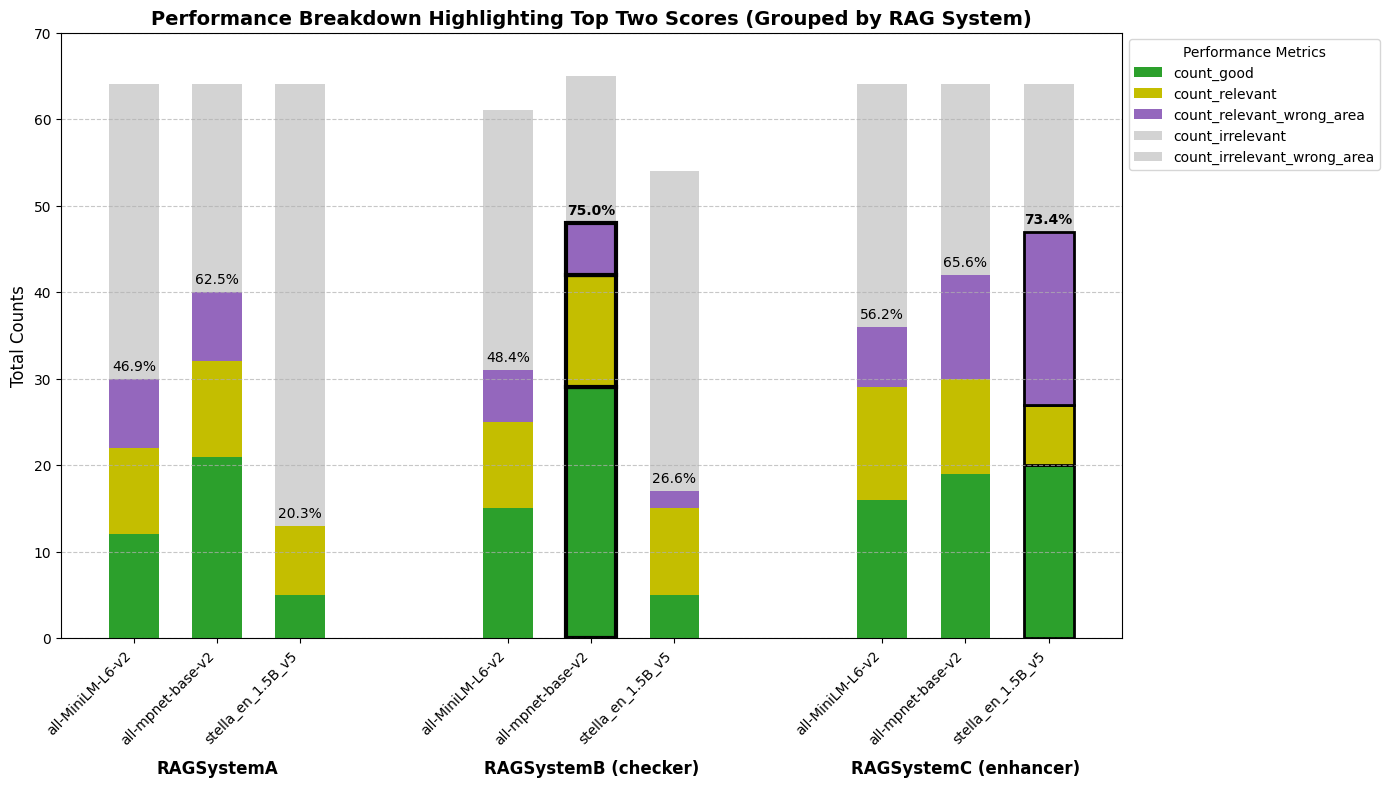

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define updated colors: include "count_relevant_wrong_area"
highlight_colors = {
    'count_good': '#2ca02c',  # Green for good
    'count_relevant': '#c4be00',  # Blue for relevant
    'count_irrelevant': '#d3d3d3',  # Gray for irrelevant
    'count_relevant_wrong_area': '#9467bd',  # Purple for relevant but wrong area
    'count_irrelevant_wrong_area': '#d3d3d3'  # Gray for irrelevant and wrong area
}

# Prepare data for plotting
rag_systems = df_grouped_counts.index.get_level_values(0).unique()
x_ticks = []
x_positions = []

fig, ax = plt.subplots(figsize=(14, 8))

# Initialize bar positions
x_base = 0
width = 0.6  # Bar width

# Calculate combined percentages for count_good + count_relevant + count_relevant_wrong_area
df_grouped_counts['percent_combined'] = (
    (df_grouped_counts['count_good'] + df_grouped_counts['count_relevant'] + df_grouped_counts['count_relevant_wrong_area']) / 64
) * 100

# Identify the top two scores
top_two_idx = df_grouped_counts['percent_combined'].nlargest(2).index
top_two_values = df_grouped_counts['percent_combined'].nlargest(2).values

# Plot stacked bars for each rag_system
for rag_system in rag_systems:
    df_subset = df_grouped_counts.loc[rag_system]
    x = np.arange(len(df_subset)) + x_base
    bottom = np.zeros(len(df_subset), dtype=float)
    for count_type in count_columns:
        color = highlight_colors[count_type]  # Apply updated colors
        bars = ax.bar(x, df_subset[count_type], width=width, label=count_type if rag_system == rag_systems[0] else "",
                      bottom=bottom, color=color)
        # Only add percentages for count_good + count_relevant + count_relevant_wrong_area
        if count_type == 'count_relevant_wrong_area':
            for i, bar in enumerate(bars):
                combined_height = (
                    bottom[i] + df_subset['count_relevant_wrong_area'].iloc[i]
                )  # Include the full stack up to relevant_wrong_area
                percent = df_subset['percent_combined'].iloc[i]
                ax.text(bar.get_x() + bar.get_width() / 2, combined_height + 1, 
                        f"{percent:.1f}%", ha='center', fontsize=10, fontweight='bold' if percent in top_two_values else 'normal')
        bottom += df_subset[count_type].values  # Update bottom for stacking

    # Add labels for rag_system grouping
    mid_x = x.mean()
    ax.text(mid_x, -15, rag_system, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transData)

    # Update x_ticks and x_positions
    x_ticks.extend(df_subset.index)
    x_positions.extend(x)
    x_base += len(df_subset) + 1.5  # Add more space between rag_system groups

# Highlight the top two combined percentage bars (split into stacks)
for idx, value in zip(top_two_idx, top_two_values):
    highlight_values = df_grouped_counts.loc[idx, ['count_good', 'count_relevant', 'count_relevant_wrong_area']]
    highlight_bottom = 0
    x_highlight = x_positions[list(df_grouped_counts.index).index(idx)]
    for metric, stack_value in highlight_values.items():
        ax.bar(x_highlight, stack_value, width=width, color=highlight_colors[metric],
               edgecolor='black', linewidth=3 if value == top_two_values[0] else 2, bottom=highlight_bottom)
        highlight_bottom += stack_value

# Adjust y-axis height
ax.set_ylim(0, 70)

# Formatting
plt.title("Performance Breakdown Highlighting Top Two Scores (Grouped by RAG System)", fontsize=14, fontweight='bold')
plt.ylabel("Total Counts", fontsize=12)
plt.xticks(x_positions, x_ticks, rotation=45, ha='right', fontsize=10)
plt.legend(title="Performance Metrics", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


## Golden route

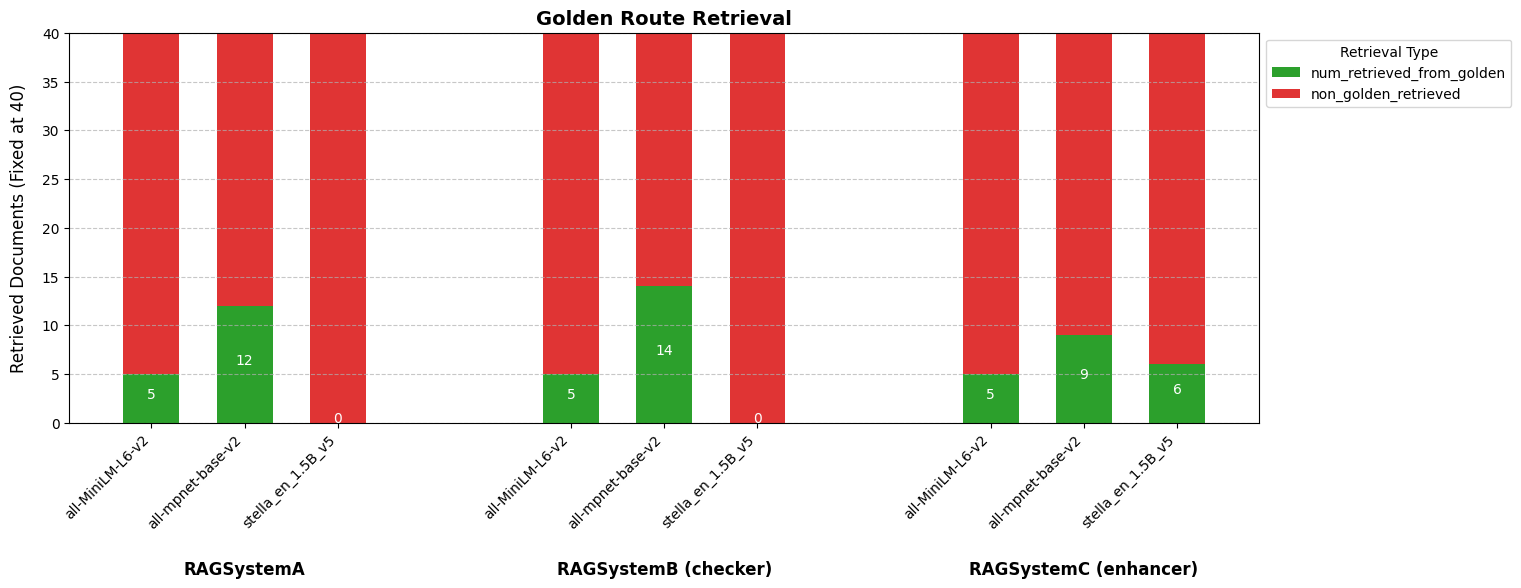

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'num_retrieved_from_golden' is numeric
df_combined['num_retrieved_from_golden'] = pd.to_numeric(df_combined['num_retrieved_from_golden'], errors='coerce').fillna(0)

# Use shortened embedding model names
df_combined["short_embedding_model"] = df_combined["embedding_model"].apply(lambda x: x.split("/")[-1])

# Compute non-golden retrieved (remainder to make total height 40)
df_combined['non_golden_retrieved'] = 40 - df_combined['num_retrieved_from_golden']
df_combined['non_golden_retrieved'] = df_combined['non_golden_retrieved'].clip(lower=0)  # Ensure non-negative values

# Aggregate by RAG system and embedding model (SUM, not scaling)
df_grouped_golden = df_combined.groupby(["rag_system", "short_embedding_model"])[['num_retrieved_from_golden', 'non_golden_retrieved']].sum()

# Define colors
golden_colors = {
    'num_retrieved_from_golden': '#2ca02c',  # Green for golden route
    'non_golden_retrieved': '#e03434'  # Red for non-golden route
}

# Prepare data for plotting
rag_systems = df_grouped_golden.index.get_level_values(0).unique()
x_ticks = []
x_positions = []

fig, ax = plt.subplots(figsize=(14, 6))  # Adjust figure size

# Initialize bar positions
x_base = 0
width = 0.6  # Bar width

# Plot stacked bars for each rag_system
for rag_system in rag_systems:
    df_subset = df_grouped_golden.loc[rag_system]
    x = np.arange(len(df_subset)) + x_base
    bottom = np.zeros(len(df_subset), dtype=float)
    
    for count_type in ['num_retrieved_from_golden', 'non_golden_retrieved']:
        bars = ax.bar(x, df_subset[count_type], width=width, label=count_type if rag_system == rag_systems[0] else "",
                      bottom=bottom, color=golden_colors[count_type])
        
        # Add values on top of the stack for clarity (for green only)
        if count_type == 'num_retrieved_from_golden':
            for i, bar in enumerate(bars):
                ax.text(bar.get_x() + bar.get_width() / 2, bottom[i] + df_subset[count_type].iloc[i] / 2, 
                        f"{df_subset[count_type].iloc[i]:.0f}", ha='center', fontsize=10, color='white')

        bottom += df_subset[count_type].values  # Update bottom for stacking
    
    # Add labels for rag_system grouping
    mid_x = x.mean()
    ax.text(mid_x, -15, rag_system, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transData)

    # Update x_ticks and x_positions
    x_ticks.extend(df_subset.index)
    x_positions.extend(x)
    x_base += len(df_subset) + 1.5  # Add more space between rag_system groups

# Ensure all bars reach 40 in height
ax.set_ylim(0, 40)

# Formatting
plt.title("Golden Route Retrieval", fontsize=14, fontweight='bold')
plt.ylabel("Retrieved Documents (Fixed at 40)", fontsize=12, labelpad=10)
plt.xticks(x_positions, x_ticks, rotation=45, ha='right', fontsize=10)
plt.legend(title="Retrieval Type", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to remove excess white space
plt.subplots_adjust(left=0.1, right=0.95, top=0.85, bottom=0.2)

# Show plot
plt.show()


In [25]:
# Ensure numeric values
df_combined['num_retrieved_from_golden'] = pd.to_numeric(df_combined['num_retrieved_from_golden'], errors='coerce').fillna(0)

# Use shortened embedding model names
df_combined["short_embedding_model"] = df_combined["embedding_model"].apply(lambda x: x.split("/")[-1])

# Aggregate sum of num_retrieved_from_golden
golden_sums = df_combined.groupby(["rag_system", "short_embedding_model"])['num_retrieved_from_golden'].sum()
golden_sums

rag_system             short_embedding_model
RAGSystemA             all-MiniLM-L6-v2          5
                       all-mpnet-base-v2        12
                       stella_en_1.5B_v5         0
RAGSystemB (checker)   all-MiniLM-L6-v2          5
                       all-mpnet-base-v2        14
                       stella_en_1.5B_v5         0
RAGSystemC (enhancer)  all-MiniLM-L6-v2          5
                       all-mpnet-base-v2         9
                       stella_en_1.5B_v5         6
Name: num_retrieved_from_golden, dtype: int64

## Easy / hard queries

In [63]:
# Ensure numeric columns
count_columns = [
    'num_retrieved_from_golden', 
    'count_good', 
    'count_relevant', 
    'count_relevant_wrong_area'
]
df_combined[count_columns] = df_combined[count_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Aggregate counts per query
query_counts = df_combined.groupby('query').agg({
    'num_retrieved_from_golden': 'sum',  # Golden retrieved counts
    'count_good': 'sum',  # Good counts
    'count_relevant': 'sum',  # Relevant counts
    'count_irrelevant':'sum',
    'count_relevant_wrong_area': 'sum',  # Wrong location counts
    'count_irrelevant_wrong_area':'sum'
})

# Add a combined column for Good + Relevant
query_counts['good_plus_relevant'] = query_counts['count_good'] + query_counts['count_relevant']
query_counts['wrong_areas'] = query_counts['count_relevant_wrong_area'] + query_counts['count_irrelevant_wrong_area']
query_counts['irrelevant'] = query_counts['count_irrelevant'] + query_counts['count_irrelevant_wrong_area']

# Display the result
print("Query Counts Based on Metrics")
query_counts


Query Counts Based on Metrics


,num_retrieved_from_golden,count_good,count_relevant,count_irrelevant,count_relevant_wrong_area,count_irrelevant_wrong_area,good_plus_relevant,wrong_areas,irrelevant
query,,,,,,,,,
I like metro systems. Which stations are interesting in Amsterdam?,0,13,27,24,6,2,40,8,26
I want to see the most famous bridges of Amsterdam,0,9,13,46,2,2,22,4,48
What should Rembrandt lover see in Leiden?,13,13,7,21,11,13,20,24,34
What should a museum nerd see in Haarlem,23,28,3,8,18,15,31,33,23
What to see in Amsterdam to learn about the jewish heritage,4,24,9,19,9,12,33,21,31
brutalist architecture Amsterdam,5,16,15,28,1,11,31,12,39
skyscrapers in the Hague,6,21,10,21,18,2,31,20,23
the palaces of the Hague,5,18,9,18,4,18,27,22,36
